In [6]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
%matplotlib inline

# Função para calcular moda.
from scipy import stats

# Formatação dos gráficos
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

import statsmodels.api as sm

#TODO:
#Definiçao da metrica de jitter no texto
#Grafico apenas dos trafegos que foram movidos em 350s - ok
#Formataçao dos graficos (legenda, cor)
#Linha com a média no grafico de jitter

In [7]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0, "legend.title_fontsize": 13.75}
sns.set (style="whitegrid", font_scale=1.35, rc=myrcs)
sns.set_palette (sns.color_palette (["#b2df8a", "#33a02c", "#cab2d6", "#6a3d9a"]))
sns.set_palette (sns.color_palette (["#b2df8a", "#33a02c", "#fdbf6f", "#ff7f00"]))
sns.set_palette (sns.color_palette ("Paired"))

# Linhas exibidas por padrão nos dataframes
pd.options.display.min_rows = 20

In [8]:
#Configurações
# A5 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 5)
# A5 = (HW = 1; SW = 1-5)

# Parâmetros que variam nesta simulação
seeds = [1,2]
cargas = ["50hosts", "100hosts"] #"50hosts", "100hosts",
experimentos = ["a5"]

# Tempo total de simulação
t_sim = 2000

# Intervalo de confiança
confianca = 99

# Imprimir titulos nos gráficos
titulos = False

# Salvar graficos
salvarGraficos = False

In [9]:
def read_df_saidaStruct ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-saidaStruct.log", sep='\s+', index_col=["Cookie"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_cache ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-traffic-qos-l7-app.log", sep='\s+', index_col=["Teid"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_ping ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingStats.zip", sep='\s+', compression='zip', index_col=["Cookie"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High", "Time:s": "Time"}, inplace=True)
    return df_read

def read_df_regrasMovidas ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-RegrasMovidas.log", sep='\s+', index_col=["Cookie"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

In [5]:
df_regrasMovidas = read_df_regrasMovidas()
df_regrasMovidas.drop(columns=["SRC","DST","SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches","InCache", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
df_ping = read_df_ping()
df_saidaStruct = read_df_saidaStruct()
df_saidaStruct.drop(columns=["SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
df_concatenado = pd.merge(df_ping, df_saidaStruct, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_concatenado = pd.merge(df_concatenado, df_regrasMovidas, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_concatenado.reset_index(inplace = True)
df_concatenado.query("TimeSec == 350.0",inplace = True)
df_ping = 0
df_saidaStruct = 0
df_concatenado = df_concatenado.groupby(["Load", "InCache", "Time:s"]).mean()
df_concatenado.reset_index(inplace = True)
#df_concatenado

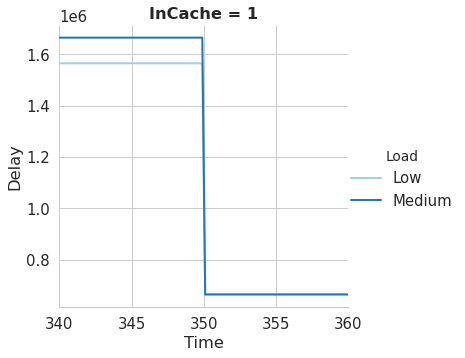

In [6]:
snsplt = sns.relplot(x="Time:s", y="Delay:ns", hue="Load" , col="InCache", kind="line", legend=True, 
                      data=df_concatenado, ci=confianca, markers=True)
#plt.title('50Hosts - Delay')
snsplt.set_axis_labels("Time", "Delay")
if (titulos):
    snsplt.fig.suptitle('50 hosts em 350s - Delay', y=1.05)
#snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(340, 360))
if (salvarGraficos):
    snsplt.savefig("50hostsEm350-delay.pdf")

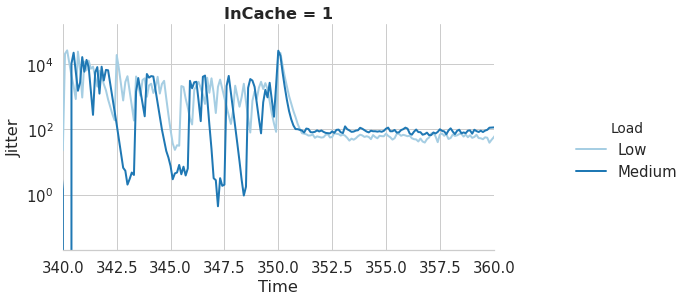

In [7]:
snsplt = sns.relplot(x="Time:s", y="Jitter:ns", hue="Load", col="InCache", kind="line", legend=True, 
                      data=df_concatenado, ci=confianca, markers=True)
#plt.title('50Hosts- Jitter')
snsplt.set_axis_labels("Time", "Jitter")
if (titulos):
    snsplt.fig.suptitle('50 hosts em 350s - Jitter', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(340, 360))
#snsplt.set(ylim=(0, 10000))
snsplt.set(yscale="log")
if (salvarGraficos):
    snsplt.savefig("50hostsEm350-jitter.pdf")

In [10]:
df_ping = read_df_ping()
df_saidaStruct = read_df_saidaStruct()
df_saidaStruct.drop(columns=["SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
df_concatenado = pd.merge(df_ping, df_saidaStruct, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_concatenado.reset_index(inplace=True)
df_ping = 0
df_saidaStruct = 0
#Esse query pra pegar o intervalo estável não funcionou aqui
#df_concatenado = df_concatenado.query("Time:s >= 250.0 and Time:s <= 400.0").groupby(["Load","InCache", "Time:s"]).mean()
#df_concatenado.reset_index(inplace = True)

,Cookie,Load,Experimento,Seed,Time:s,Delay:ns,Jitter:ns,InCache
0,0x05a059278575a511,Low,a5,1,201.0,1564848.0,97803.0,1
1,0x05a059278575a511,Low,a5,1,201.0,1564848.0,91690.0,1
2,0x05a059278575a511,Low,a5,1,201.0,1564848.0,85959.0,1
3,0x05a059278575a511,Low,a5,1,201.0,1564848.0,80586.0,1
4,0x05a059278575a511,Low,a5,1,201.1,1564848.0,75549.0,1
5,0x05a059278575a511,Low,a5,1,201.1,1564848.0,70827.0,1
6,0x05a059278575a511,Low,a5,1,201.1,1564848.0,66400.0,1
7,0x05a059278575a511,Low,a5,1,201.1,1564848.0,62250.0,1
8,0x05a059278575a511,Low,a5,1,201.1,1564848.0,58359.0,1
9,0x05a059278575a511,Low,a5,1,201.1,1564848.0,54711.0,1


In [ ]:
snsplt = sns.relplot(x="Time:s", y="Delay:ns", col="InCache", kind="line", legend=True, 
                      data=df_concatenado, ci=confianca, markers=True)
#plt.title('50Hosts - Delay')
snsplt.set_axis_labels("Time", "Delay")
if (titulos):
    snsplt.fig.suptitle('50 e 100 hosts - Delay', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))
if (salvarGraficos):
    snsplt.savefig("50e100hosts-delay.pdf")

ValueError: `legend` must be 'brief', 'full', or False

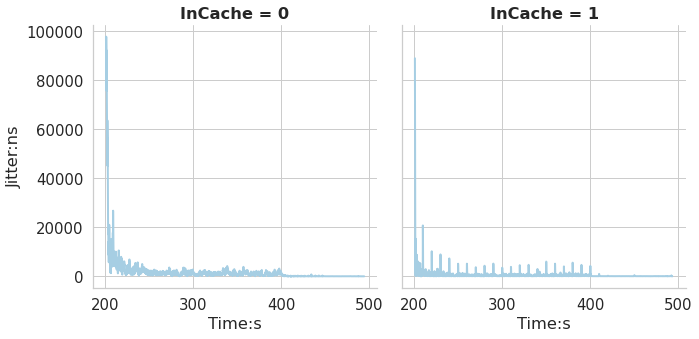

In [10]:
snsplt = sns.relplot(x="Time:s", y="Jitter:ns", col="InCache", kind="line", legend=True, 
                      data=df_concatenado, ci=confianca, markers=True)
#plt.title('50Hosts- Jitter')
snsplt.set_axis_labels("Time", "Jitter")
if (titulos):
    snsplt.fig.suptitle('50 e 100 hosts - Jitter', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))
#snsplt.set(ylim=(0, 10000))
snsplt.set(yscale="log")
if (salvarGraficos):
    snsplt.savefig("50e100hosts-jitter.pdf")

In [11]:
cargas = ["100hosts"]
df_ping = read_df_ping()
df_saidaStruct = read_df_saidaStruct()
df_saidaStruct.drop(columns=["SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
df_concatenado = pd.merge(df_ping, df_saidaStruct, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_concatenado.reset_index(inplace=True)
df_ping = 0
df_saidaStruct = 0
df_concatenado = df_concatenado.groupby(["InCache", "Time:s"]).mean()
df_concatenado.reset_index(inplace = True)

ValueError: `legend` must be 'brief', 'full', or False

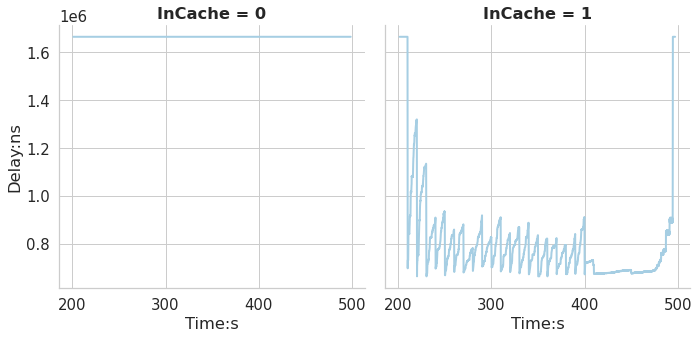

In [12]:
snsplt = sns.relplot(x="Time:s", y="Delay:ns", col="InCache", kind="line", legend=True, 
                      data=df_concatenado, ci=confianca, markers=True)
#plt.title('100Hosts- Delay')
snsplt.set_axis_labels("Time", "Delay")
if (titulos):
    snsplt.fig.suptitle('100 hosts - Delay', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))

if (salvarGraficos):
    snsplt.savefig("100hosts-delay.pdf")

ValueError: `legend` must be 'brief', 'full', or False

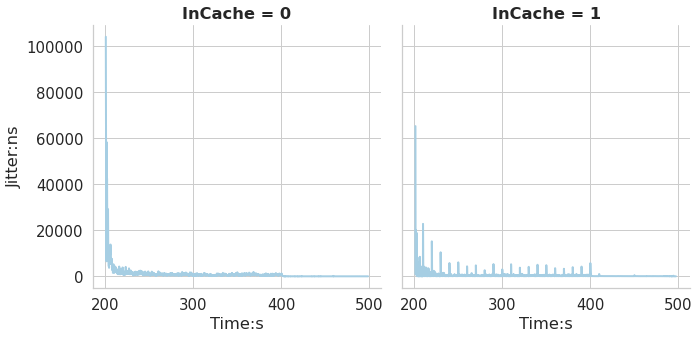

In [13]:
snsplt = sns.relplot(x="Time:s", y="Jitter:ns", col="InCache", kind="line", legend=True, 
                      data=df_concatenado, ci=confianca, markers=True)
#plt.title('100Hosts - Jitter')
snsplt.set_axis_labels("Time", "Jitter")
if (titulos):
    snsplt.fig.suptitle('100 hosts - Jitter', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))

if (salvarGraficos):
    snsplt.savefig("100hosts-jitter.pdf")

In [14]:
cargas = ["150hosts"]
df_ping = read_df_ping()
df_saidaStruct = read_df_saidaStruct()
df_saidaStruct.drop(columns=["SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
df_concatenado = pd.merge(df_ping, df_saidaStruct, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_concatenado.reset_index(inplace=True)
df_ping = 0
df_saidaStruct = 0
df_concatenado = df_concatenado.groupby(["InCache", "Time:s"]).mean()
df_concatenado.reset_index(inplace = True)

ValueError: `legend` must be 'brief', 'full', or False

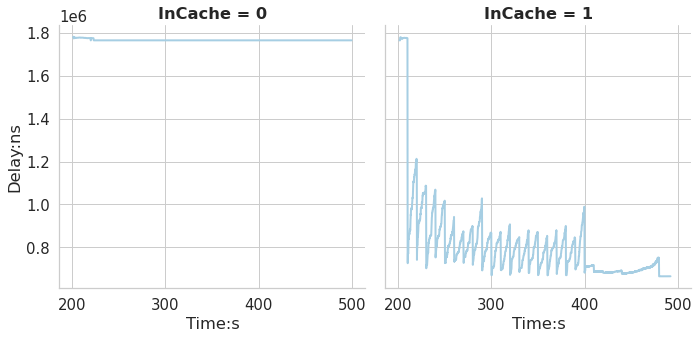

In [15]:
snsplt = sns.relplot(x="Time:s", y="Delay:ns", col="InCache", kind="line", legend=True, 
                      data=df_concatenado, ci=confianca, markers=True)
#plt.title('150Hosts - Delay')
snsplt.set_axis_labels("Time", "Delay")
if (titulos):
    snsplt.fig.suptitle('150 hosts - Delay', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))

if (salvarGraficos):
    snsplt.savefig("150hosts-delay.pdf")

ValueError: `legend` must be 'brief', 'full', or False

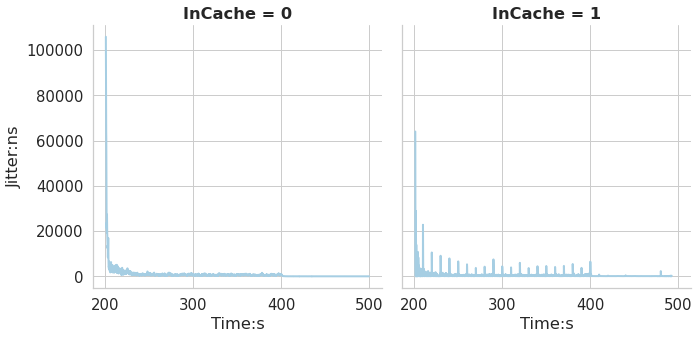

In [16]:
snsplt = sns.relplot(x="Time:s", y="Jitter:ns", col="InCache", kind="line", legend=True, 
                      data=df_concatenado, ci=confianca, markers=True)
#plt.title('150Hosts - Jitter')
snsplt.set_axis_labels("Time", "Jitter")
if (titulos):
    snsplt.fig.suptitle('150 hosts - Jitter', y=1.05)
snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
snsplt.set(xlim=(250, 400))

if (salvarGraficos):
    snsplt.savefig("150hosts-jitter.pdf")